# Data analysis and visualization of gas mileage in my rx8

## Background

I've collected information at each gas fill up for the past few years: the date, miles driven since last fill up, amount of gas pumped into the tank, and the price per gallon. Each time the tank was filled up completely, allowing the average miles per gallon to be computed over the past tank. The pumps probably don't fill the tank up to the exact same amount each time, but it should be roughly close enough.

Modern cars have trip computers that can record a lot more information and give an instantaneous mileage calculation. It would be interesting to have that much data and take different factors into account, such as air temperature, tire pressure, etc. The biggest source of variation in mileage for my driving pattern is likely the number of cold starts in a day, of which I did not collect data.

# Summary of process and tools used

1. Record gas data in spreadsheet, and export as csv file
2. Load csv file into local MySQL database
3. Run Python through Jupyter Notebook
4. Connect to MySQL database using Python
5. Perform data analysis and visualization in Python
6. Control versions and save to Github using Git
7. Done on Mac OS X with Bash shell

## Exploratory data analysis

First we load packages.

In [1]:
import MySQLdb as mdb
import sys
import pandas as pd
import pandas.io.sql
import numpy as np
from numpy import log
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
import scipy.stats

Next we connect to the MySQL database and load the entire table as a pandas dataframe.

In [2]:
con = mdb.connect(host='localhost', db='mpg_db', read_default_file='~/.my.cnf')
gas_data = pd.read_sql("SELECT * FROM mpg_table", con)
con.close()

In [3]:
print(type(gas_data)) #shows type as pandas dataframe
#print(gas_data) #shows the table
print(list(gas_data)) #shows some info about the fields in the table

<class 'pandas.core.frame.DataFrame'>
['thedate', 'days', 'odometer', 'miles', 'gallons', 'cost', 'costpergal', 'station', 'style', 'mpg', 'mpdol', 'dolpm', 'mpd', 'gpd', 'dolpd']


Here's an example of using the dataframe to get the mean of the mpg column.

In [4]:
print('%.2f' % np.mean(gas_data['mpg'])) #prints two decimal places

14.42


Now we plot the mileage over time. The vertical line will be expalined shortly.

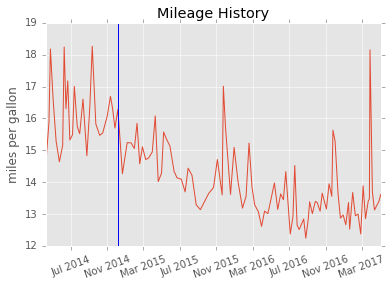

In [5]:
plt.plot_date(matplotlib.dates.date2num(gas_data['thedate']), 
              gas_data['mpg'], '-')
plt.axvline(x=datetime.strptime('2014-12-07','%Y-%m-%d').date())
plt.title('Mileage History')
plt.ylabel('miles per gallon')
plt.xticks(rotation=20)
plt.show()

Here we make a boxplot of the overall mileage.

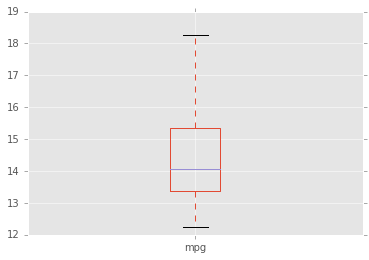

In [6]:
gas_data['mpg'].plot.box() #pandas wrapper of matplotlib?
#plt.boxplot(gas_data['mpg']) #alternative
plt.show()

Here's a plot of gas prices over time. Costco is significantly cheaper than other stations, so the graph is misleading in general. The second plot distinguishes between stations.

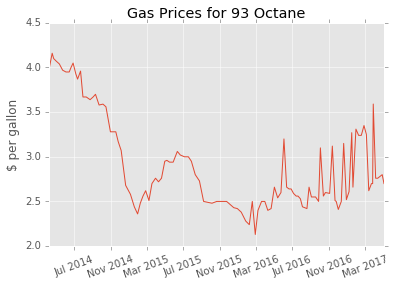

In [7]:
plt.plot_date(matplotlib.dates.date2num(gas_data['thedate']), 
                         gas_data['costpergal'], '-') #time-mpg
plt.title('Gas Prices for 93 Octane')
plt.ylabel('$ per gallon')
plt.xticks(rotation=20)
plt.show()

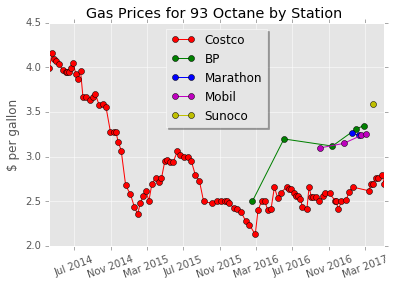

In [8]:
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Costco'].thedate), 
              gas_data[gas_data.station=='Costco'].costpergal, 'r-o', label='Costco')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='BP'].thedate), 
              gas_data[gas_data.station=='BP'].costpergal, 'g-o', label='BP')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Marathon'].thedate), 
              gas_data[gas_data.station=='Marathon'].costpergal, 'b-o', label='Marathon')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Mobil'].thedate), 
              gas_data[gas_data.station=='Mobil'].costpergal, 'm-o', label='Mobil')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.station=='Sunoco'].thedate), 
              gas_data[gas_data.station=='Sunoco'].costpergal, 'y-o', label='Sunoco')
#clean this up into a loop
              
#gas_data[gas_data.station=='BP'].plot(x='thedate', y='costpergal', color='blue') 
#pandas wrapper
plt.xticks(rotation=20)
plt.title('Gas Prices for 93 Octane by Station ')
plt.ylabel('$ per gallon')
plt.legend(loc='upper center', shadow='true') #move outside of graph to right
plt.show()

How much cheaper was Costco on Average? Let's take a rough estimation by looking at the average price of Costco gas from about September 2016 to March 2017 (where the other stations are clustered) and compare it to the average for the other stations over that time span.

In [9]:
starttime = datetime.strptime('2016-09-26','%Y-%m-%d').date()
endtime = datetime.strptime('2017-03-07','%Y-%m-%d').date()
daterange_df = gas_data[(gas_data.thedate>=starttime)  & (gas_data.thedate<=endtime)]
#daterange_df[['thedate', 'station', 'costpergal']]

print 'Mean Costco price: ', daterange_df[daterange_df.station=='Costco'].costpergal.mean()
print 'Mean non-Costco price: ', daterange_df[daterange_df.station!='Costco'].costpergal.mean()
print 'Difference: ', daterange_df[daterange_df.station!='Costco'].costpergal.mean()-daterange_df[daterange_df.station=='Costco'].costpergal.mean()

#daterange_df[daterange_df.station!='Costco'][['thedate', 'station', 'costpergal']]
#gas_data[['thedate', 'station', 'costpergal']][:109]

Mean Costco price:  2.54081818182
Mean non-Costco price:  3.22455555556
Difference:  0.683737373737


The following is a plot of mileage given the number of miles driven per day. The MpD is used as an indicator of highway driving, and we expect highway driving to produce better MpG.

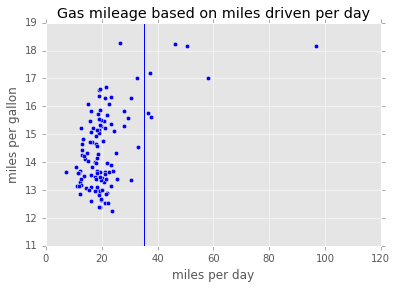

Number of data points past cutoff: 7


In [10]:
plt.scatter(gas_data['mpd'], gas_data['mpg'])
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Gas mileage based on miles driven per day')

cutoff=35 #set cutoff between city and mixed
plt.axvline(cutoff)

plt.show()

print 'Number of data points past cutoff: {}'.format(gas_data[gas_data.mpd>=cutoff].shape[0])

Now let's make two boxplots grouped by what looks like city mileage and mixed highway mileage.

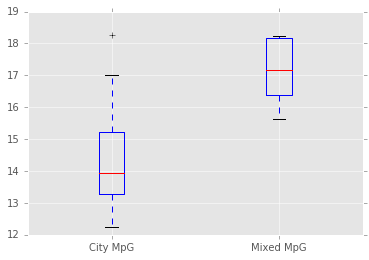

In [11]:
#fig = plt.figure()
#ax = fig.add_subplot(111)
plt.boxplot([gas_data[gas_data.mpd<cutoff].mpg,gas_data[gas_data.mpd>=cutoff].mpg])
plt.xticks([1, 2], ['City MpG', 'Mixed MpG'])
plt.show()
#gas_data[(gas_data.mpd>cutoff) & (gas_data.station=='Costco')].mpg
#above shows how t select multiple conditions

Here's a graph for the two different drive styles.

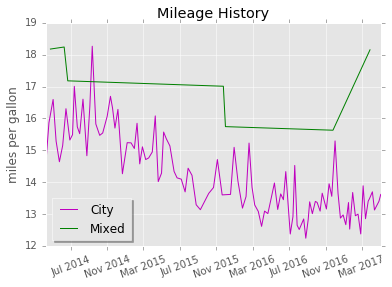

In [12]:
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.mpd<cutoff].thedate), 
              gas_data[gas_data.mpd<cutoff].mpg, 'm-', label='City')
plt.plot_date(matplotlib.dates.date2num(gas_data[gas_data.mpd>=cutoff].thedate), 
              gas_data[gas_data.mpd>=cutoff].mpg, 'g-', label='Mixed')

plt.title('Mileage History')
plt.ylabel('miles per gallon')
plt.legend(loc='lower left', shadow='true')
plt.xticks(rotation=20)
plt.show()

New tires were put on after the December 6th, 2014 fill up. These tires had a stickier compund which reduced the mileage.

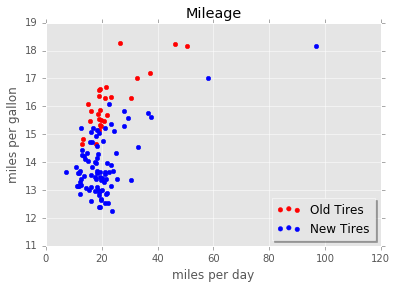

In [13]:
#gas_data[gas_data.thedate<datetime.strptime('2014-12-07','%Y-%m-%d').date()].mpd
#also consider num2date from matplotlib
tire_date=datetime.strptime('2014-12-07','%Y-%m-%d').date() #when tires were changed

plt.scatter(gas_data[gas_data.thedate<tire_date].mpd, 
            gas_data[gas_data.thedate<tire_date].mpg, 
            color='red', label='Old Tires')
plt.scatter(gas_data[gas_data.thedate>tire_date].mpd, 
            gas_data[gas_data.thedate>tire_date].mpg, 
            color='blue', label='New Tires')
plt.title('Mileage')
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.legend(loc='lower right', shadow='true')
plt.show()

Here are the mean mpgs for the old and new tires.

In [14]:
print 'MpG for old tires: ', gas_data[gas_data.thedate<tire_date].mpg.mean()
print 'MpG for new tires: ', gas_data[gas_data.thedate>=tire_date].mpg.mean()
print 'Difference in means: ', gas_data[gas_data.thedate<tire_date].mpg.mean()-gas_data[gas_data.thedate>=tire_date].mpg.mean()

MpG for old tires:  16.1160974074
MpG for new tires:  13.8999417241
Difference in means:  2.21615568327


Here's Welch's t-test

In [15]:
print scipy.stats.ttest_ind(gas_data[gas_data.thedate<tire_date].mpg, 
                            gas_data[gas_data.thedate>=tire_date].mpg, equal_var=False)
print 'Taking a smaller sample out of the new tires:'
print scipy.stats.ttest_ind(gas_data[gas_data.thedate<tire_date].mpg, 
                            gas_data[gas_data.thedate>=tire_date].mpg.sample(n=30), equal_var=False)

Ttest_indResult(statistic=9.8000287124073324, pvalue=7.8382049025200846e-13)
Taking a smaller sample out of the new tires:
Ttest_indResult(statistic=7.1856587125522191, pvalue=1.8769628413892097e-09)


Let's look at box plots comparing the old and new tires now.

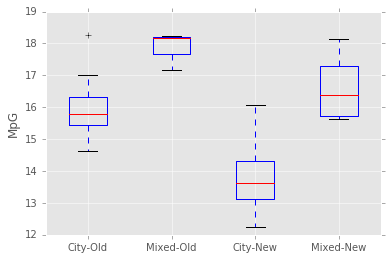

In [16]:
cutoff=35 #set cutoff between two groups

plt.boxplot([gas_data[(gas_data.mpd<cutoff)  & (gas_data.thedate<tire_date)].mpg, 
             gas_data[(gas_data.mpd>=cutoff) & (gas_data.thedate<tire_date)].mpg, 
             gas_data[(gas_data.mpd<cutoff)  & (gas_data.thedate>tire_date)].mpg,
             gas_data[(gas_data.mpd>=cutoff) & (gas_data.thedate>tire_date)].mpg
            ])
plt.xticks([1, 2, 3, 4], ['City-Old', 'Mixed-Old', 'City-New', 'Mixed-New'])
plt.ylabel('MpG')
plt.show()
##gas_data[(gas_data.mpd>cutoff) & (gas_data.station=='Costco')].mpg
##gas_data[(gas_data.mpd>cutoff) & (gas_data.thedate<datetime.strptime('2014-12-07','%Y-%m-%d').date())].mpg

## Regression analysis

Here we run a linear regression using the statsmodel library.

In [17]:
regression = smf.ols(formula = 'mpg ~ mpd', data = gas_data).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     44.47
Date:                Mon, 05 Jun 2017   Prob (F-statistic):           1.02e-09
Time:                        15:40:44   Log-Likelihood:                -182.15
No. Observations:                 114   AIC:                             368.3
Df Residuals:                     112   BIC:                             373.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.9140      0.253     51.011      0.0

Here's an alternative method to get some regression data using the scikit library.

In [18]:
mpg_data2 = gas_data[['mpg']]
mpd_data2 = gas_data[['mpd']]
sk_regr = linear_model.LinearRegression()
sk_regr.fit(mpd_data2, mpg_data2)
print 'coefficient: {0:.4f}'.format(sk_regr.coef_[0][0])
print 'intercept: {0:.4f}'.format(sk_regr.intercept_[0])
print 'R-squared: {0:.3f}'.format(sk_regr.score(mpd_data2, mpg_data2))

coefficient: 0.0723
intercept: 12.9140
R-squared: 0.284


We can see the data matches up with both methods. This linear model isn't a great fit, as indicated by the R-squared value. Let's plot it over the scatter plot from earlier.

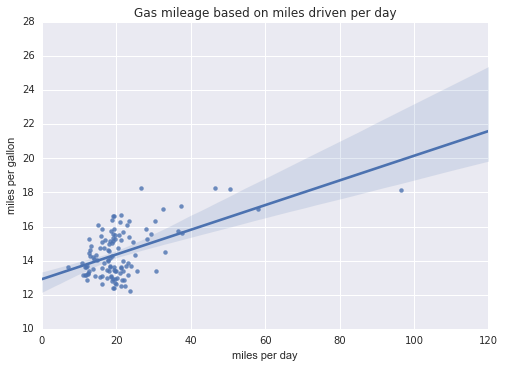

In [19]:
import seaborn as sns
sns.regplot(gas_data['mpd'], gas_data['mpg']) #with seaborn
#next two lines would plot the line directly
#x = np.arange(0, 100)
#plt.plot(sk_regr.coef_[0][0]*x+sk_regr.intercept_[0], 'r')
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Gas mileage based on miles driven per day')
plt.show()

Here's a locally weighted model.

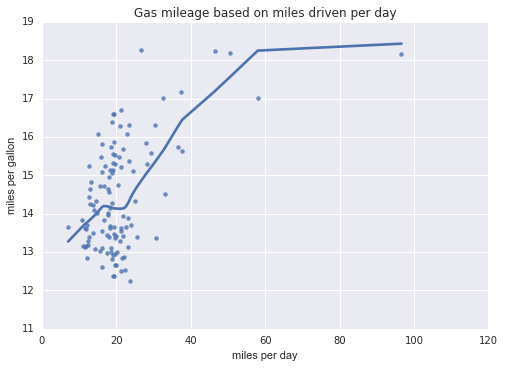

In [20]:
import seaborn as sns
sns.regplot(gas_data['mpd'], gas_data['mpg'], lowess=True)
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Gas mileage based on miles driven per day')
plt.show()

Let's plot two lines based on the old and new tires.

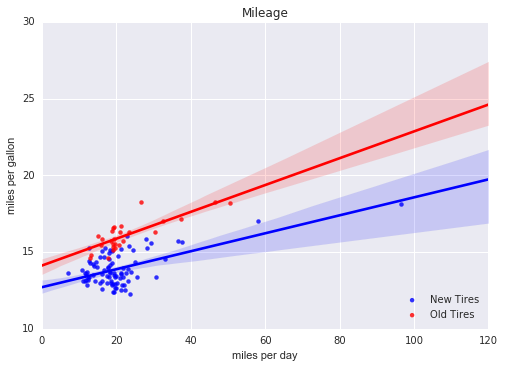

In [21]:
sns.regplot(gas_data[gas_data.thedate>tire_date].mpd, 
            gas_data[gas_data.thedate>tire_date].mpg,
            color='blue', label='New Tires')
sns.regplot(gas_data[gas_data.thedate<tire_date].mpd, 
            gas_data[gas_data.thedate<tire_date].mpg,
            color='red', label='Old Tires')
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Mileage')
plt.legend(loc='lower right')
plt.show()

And here's the locally weighted models.

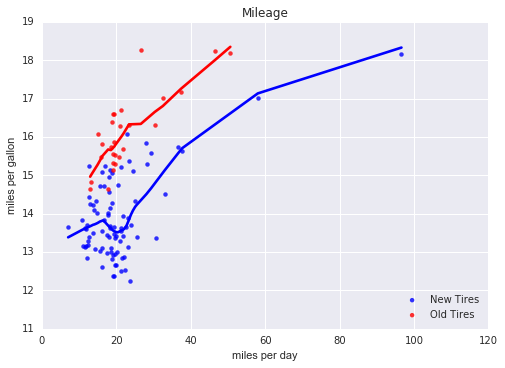

In [22]:
sns.regplot(gas_data[gas_data.thedate>tire_date].mpd, 
            gas_data[gas_data.thedate>tire_date].mpg,
            color='blue', label='New Tires', lowess=True)
sns.regplot(gas_data[gas_data.thedate<tire_date].mpd, 
            gas_data[gas_data.thedate<tire_date].mpg,
            color='red', label='Old Tires', lowess=True)
plt.ylabel('miles per gallon')
plt.xlabel('miles per day')
plt.title('Mileage')
plt.legend(loc='lower right')
plt.show()

Here's some linear regression information for the old and new tires done separately. It looks like we have a better result for the old tires.

In [23]:
print'Old Tires'
mpg_data_O = gas_data[gas_data.thedate<tire_date][['mpg']]
mpd_data_O = gas_data[gas_data.thedate<tire_date][['mpd']]
sk_regr_O = linear_model.LinearRegression()
sk_regr_O.fit(mpd_data_O, mpg_data_O)
print 'coefficient: {0:.4f}'.format(sk_regr_O.coef_[0][0])
print 'intercept: {0:.4f}'.format(sk_regr_O.intercept_[0])
print 'R-squared: {0:.3f}'.format(sk_regr_O.score(mpd_data_O, mpg_data_O))

print '\n' + 'New Tires'
mpg_data_N = gas_data[gas_data.thedate>tire_date][['mpg']]
mpd_data_N = gas_data[gas_data.thedate>tire_date][['mpd']]
sk_regr_N = linear_model.LinearRegression()
sk_regr_N.fit(mpd_data_N, mpg_data_N)
print 'coefficient: {0:.4f}'.format(sk_regr_N.coef_[0][0])
print 'intercept: {0:.4f}'.format(sk_regr_N.intercept_[0])
print 'R-squared: {0:.3f}'.format(sk_regr_N.score(mpd_data_N, mpg_data_N))

Old Tires
coefficient: 0.0874
intercept: 14.1235
R-squared: 0.638

New Tires
coefficient: 0.0585
intercept: 12.7123
R-squared: 0.343


We can also try a log model, however the fit appears to be even worse.

In [24]:
gas_data['log_mpd'] = log(gas_data['mpd'])
gas_data['log_mpg'] = log(gas_data['mpg'])
log_lm = smf.ols(formula = 'log_mpg ~ log_mpd', data = gas_data).fit()
print(log_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                log_mpg   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     36.40
Date:                Mon, 05 Jun 2017   Prob (F-statistic):           2.12e-08
Time:                        15:40:46   Log-Likelihood:                 122.19
No. Observations:                 114   AIC:                            -240.4
Df Residuals:                     112   BIC:                            -234.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2722      0.065     34.708      0.0

## Conclusions/Actionable Insights

As seen earlier, the Costco price per gallon was about $0.68$ cents less than other gas stations. If that seems high, one other thing to keep in mind is that other gas stations also charge extra for credit cards above their posted prices, which I would use and is included here. The average fill-up would be

In [25]:
print gas_data.gallons.mean()

12.7061315789


So I could expect to save $\$8.63$ each fill-up by using Costco. I didn't have to drive out of the way to visit Costco, so it's not necessary to factor in gas costs for the trip there and back.

The Costco membership is $\$55$ per year (I think it's going up to $\$60$ now). Either way, I could expect to cover the cost of the member ship after $7$ fill-ups. On average, I would fill-up after the following number of days

In [26]:
print gas_data.days.mean()

9.90350877193


Therefore, I would cover the membership cost in about $70$ days, or $10$ weeks, if I only filled up at Costco. I could also expect to fill up about $29$ other times over the course of the year, and so I would save about $\$8.63*29\approx\$250$ by filling up at Costco for the rest of the year.

Another cost to consider is how much the new tires cost me with their poorer mileage relative to the original. I put the new tires on at about $20,000$ miles, and I'm up to about $36,000$ miles. As seen earlier, it was about $16.1$ mpg vs. $13.9$ mpg. So for $16,000$ miles, I used this much more gallons

In [27]:
print 16000*(1/13.9-1/16.1)

157.290316815


The average gas price during that time was

In [28]:
print gas_data[(gas_data.thedate>=tire_date)].costpergal.mean()

2.68349425287


So I spent about $2.68*157.29\approx\$421$ extra on gas by using this type of new tires so far. 

The original tires were also summer performance tires, and I hypothesize that fuel efficient low-rolling resistance tires would gain me an extra $2$ mpg, for about $18$ mpg on average. So had I used those hypothetical tires instead, over the same time I would have saved the following amount of dollars

In [29]:
print '$',16000*(1/13.9-1/18.1)*gas_data[(gas_data.thedate>=tire_date)].costpergal.mean()

$ 716.764632112


### Bottom line

Filling up only at Costco would save me about $\$250$ per year after the cost of membership for my driving pattern, which is only about $6,600$ miles per year of mostly city driving. Installing low rolling resistance tires would save me roughly $\$350$ a year over my current tires. I drive a relatively low number of miles, so someone who drives more could see that they could stand to save a lot by getting cheap gas and using tires that produce good mileage.

We also saw through the regression models, that the miles per day is a way to measure mixed/highway driving, and corresponds to an increase in miles per gallon as one would expect.